In [1]:
#import python library
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import codecs

Sentiment labelled sentences including amazon_cells_labelled.txt ,imdb_labelled.txt and yelp_labelled.txt are text file. So,text files are opened by codecs library.The codecs library are supporting to encode texts of utf-8. Then,concatenating texts in to dataframe 
supported by pandas library.

In [2]:
#Path of folder
original_dataset_dir = r'D:\\python\\HCL\Sentiment\sentiment_labelled_sentences\\'
list_file=[]
for file_ in os.listdir(original_dataset_dir):
    # Select texts file 
    if file_[-3:]=='txt' and file_!='readme.txt':
        #Open text use codecs library supporting text of utf-8
        f = codecs.open(original_dataset_dir+file_, encoding='utf-8',errors='ignore')
        article=[]
        # read each line of text
        for line in f:
            if line !='\n':
                article.append([file_,line])   
        #Datafram of file name and text         
        df=pd.DataFrame(article,columns=['filename','text'])
        #Collect dataframe of amazon_cells_labelled.txt ,imdb_labelled.txt and yelp_labelled.txt
        list_file.append(df)
#Concatenate all of collecting dataframe
df_concat=pd.concat(list_file).reset_index().drop(columns=['index'])
print(df_concat.tail())

               filename                                               text
2997  yelp_labelled.txt  I think food should have flavor and texture an...
2998  yelp_labelled.txt                      Appetite instantly gone.\t0\n
2999  yelp_labelled.txt  Overall I was not impressed and would not go b...
3000  yelp_labelled.txt  The whole experience was underwhelming, and I ...
3001  yelp_labelled.txt  Then, as if I hadn't wasted enough of my life ...


In [3]:
df_concat['text'][5]

'I have to jiggle the plug to get it to line up right to get decent volume.\t0\n'

In [4]:
df_concat['text'][2998]

'Appetite instantly gone.\t0\n'

Text including sentence and label are seperated by '\t' and '\n'. So, spliting use split().  

In [5]:
df_concat['text1']=df_concat['text'].apply(lambda x:x.split('\t')[0])
df_concat['label']=df_concat['text'].apply(lambda x:x.split('\t')[1] if len(x.split('\t'))==2 else '')

In [6]:
df_concat.head(2)

,filename,text,text1,label
0,amazon_cells_labelled.txt,So there is no way for me to plug it in here i...,So there is no way for me to plug it in here i...,0\n
1,amazon_cells_labelled.txt,"Good case, Excellent value.\t1\n","Good case, Excellent value.",1\n


Label column have '\n' so using replace() to delete its.

In [7]:
df_concat['label']=df_concat['label'].apply(lambda x: x.replace('\n',''))

Index of 1178 and 1968 in imdb_labelled.txt are no lable.
As index 1178 of text columns shows 'The script is', the actual is 'The script iswas there a script?' and label is '0'. 
Index 1968 of text columns shows 'Definitely worth seeing'. the actual is 'Definitely worth seeing it's the sort of thought provoking film that forces you to question your own threshold of loneliness.' and label is '1'. 

In [8]:
df_concat[df_concat['label']=='']

,filename,text,text1,label
1178,imdb_labelled.txt,The script is,The script is,
1968,imdb_labelled.txt,Definitely worth seeing,Definitely worth seeing,


In [9]:
df_concat['label'][1178]=0
df_concat['text1'][1178]='The script iswas there a script?'
df_concat['label'][1968]=1
df_concat['text1'][1968]="Definitely worth seeing it"+"'s the sort of thought provoking film that forces you to question your own threshold of loneliness."

In [10]:
df_concat[(df_concat.index==1178)|(df_concat.index==1968)]

,filename,text,text1,label
1178,imdb_labelled.txt,The script is,The script iswas there a script?,0
1968,imdb_labelled.txt,Definitely worth seeing,Definitely worth seeing it's the sort of thoug...,1


In [11]:
df_concat[df_concat['label']=='']

,filename,text,text1,label


In [12]:
df_concat.head(2)

,filename,text,text1,label
0,amazon_cells_labelled.txt,So there is no way for me to plug it in here i...,So there is no way for me to plug it in here i...,0
1,amazon_cells_labelled.txt,"Good case, Excellent value.\t1\n","Good case, Excellent value.",1


# EDA

In [13]:
#Select text1 and label columns
df=df_concat[['text1','label']]
df['label']=df['label'].astype(int)

<ipython-input-13-6c7ce0f1cfef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['label'].astype(int)


In [14]:
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import SnowballStemmer

Snowball = SnowballStemmer('english')
Porter = PorterStemmer()
Lemmatizer = WordNetLemmatizer()
Stopwords = set(stopwords.words('english'))

In [15]:
def tokenizer(sentence:str, stopword:bool=True,stemm:str=''):
    """ tokenize text , remove stop words and stemming words """
    sentence=sentence.lower()
    stemm=stemm.lower()
    #tokenize sentence
    tokenized = [word for word in word_tokenize(sentence)]
    #Delete stop words in tokenized sentence 
    if stopword:
        tokenized = [word for word in tokenized if word not in Stopwords]
    else: 
        tokenized =tokenized
    #Use stemming word in tokenized sentence
    if stemm=='lemmatizer':
        tokenized = [Lemmatizer.lemmatize(w) for w in tokenized]
    elif stemm=='snowball':
        tokenized = [Snowball.stem(w) for w in tokenized]
    elif stemm=='porter':
        tokenized = [Porter.stem(w) for w in tokenized]    
    else:
        tokenized =tokenized

    return tokenized    

The label of 0(Negative) and 1(Positive) are equally.

In [16]:
df['label'].value_counts()

0    1501
1    1501
Name: label, dtype: int64

c:\Users\aunch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


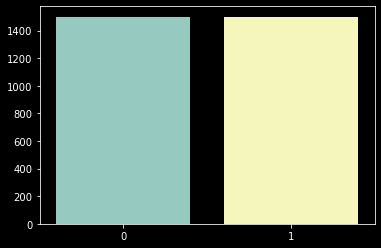

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
x = list(df['label'].value_counts().index)
y = list(df['label'].value_counts())
sns.barplot(x, y)
plt.show()

In [18]:
# tokenize sentence 
df['tokenized']=df['text1'].apply(lambda x:tokenizer(x,stopword=False))
df['tokenized_len']=df['tokenized'].apply(lambda x:len(x))

<ipython-input-18-bc3591f8cb2a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized']=df['text1'].apply(lambda x:tokenizer(x,stopword=False))


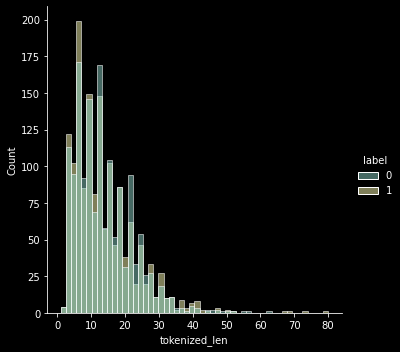

In [19]:
sns.displot(df, x="tokenized_len", hue="label")

In [20]:
df["tokenized_len"].describe()

count    3002.000000
mean       13.766156
std         8.665309
min         1.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        80.000000
Name: tokenized_len, dtype: float64

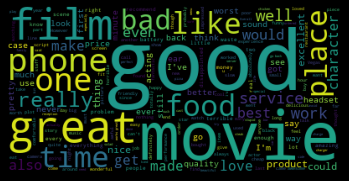

In [21]:
from wordcloud import WordCloud
text = " ".join(df['text1'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

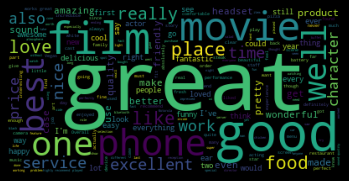

In [22]:
#Positive text
pos=df[df['label']==1]
text = " ".join(pos['text1'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

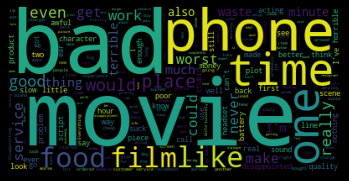

In [23]:
# Negative text
neg=df[df['label']==0]
text = " ".join(neg['text1'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

In [24]:
def Pos_selected(text):
    '''Given a string of text, tokenize the text and select type of word.'''
    sel=['JJ', 'JJR', 'JJS', 'LS', 'RB', 'RBR', 'RBS',  'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    tokenized = word_tokenize(text)
    selected_word = [word for (word, pos) in pos_tag(tokenized) if (pos in sel) and (word not in Stopwords )]
    return selected_word 

In [25]:
df['text_pos']=df['text1'].apply(lambda x:' '.join(Pos_selected(x)))

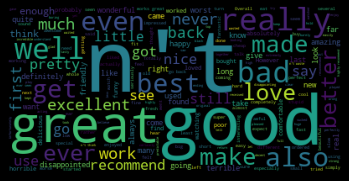

In [26]:
from wordcloud import WordCloud
text = " ".join(df['text_pos'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

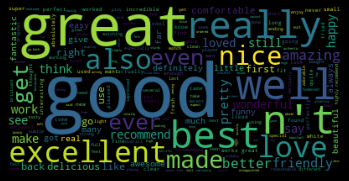

In [27]:
#Positive text
pos=df[df['label']==1]
text = " ".join(pos['text_pos'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

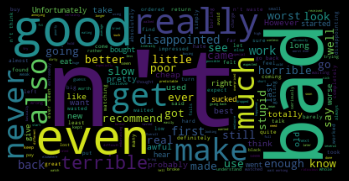

In [28]:
#Negative text
pos=df[df['label']==0]
text = " ".join(pos['text_pos'].tolist())
wordcloud = WordCloud(stopwords=Stopwords).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

# Train model 

Dataframe is seperated into Train ,Validate and Test dataset

In [29]:
from sklearn.model_selection import train_test_split
train,test1= train_test_split(df, test_size=0.3, random_state=39)
validate,test= train_test_split(test1, test_size=0.5, random_state=39)
train.shape,validate.shape,test.shape

((2101, 5), (450, 5), (451, 5))

In [30]:
def dataframe_to_list(dataframe):
    text=dataframe['text1'].tolist()
    labels=dataframe['label'].tolist()
    return text,labels

Train,validation and test convert to list of text and label.

In [31]:
train_texts, train_labels=dataframe_to_list(train)
valid_texts,  valid_labels=dataframe_to_list(validate)
test_texts,  test_labels=dataframe_to_list(validate)

Text classification use base uncased BERT that the text has been lowercased before tokenization. 

Text classification models here: https://huggingface.co/models?filter=text-classification

Maximum leangth was 128 because the average and the maximum of tokenized words were about 14 and 80 respectively. 

In [32]:
# the model use base uncased BERT
model_name = "bert-base-uncased"
# max sequence length 
max_length = 128

In [33]:
#text tokenizing use BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [34]:
target_names=list(set(df['label'].tolist()))
target_names

[0, 1]

In [35]:
# tokenize trian dataset and validation dataset 
# truncate the sentence  while the words of sentence is more than max_length
# pad with 0 the sentence  while the words of sentence is less than max_length
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [36]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [37]:
tokenizer.decode(train_encodings['input_ids'][0]) 

'[CLS] we literally sat there for 20 minutes with no one asking to take our order. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [38]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsDataset(train_encodings, train_labels)
valid_dataset = NewsDataset(valid_encodings, valid_labels)

In [39]:
train_dataset[0]

{'input_ids': tensor([ 101, 2057, 6719, 2938, 2045, 2005, 2322, 2781, 2007, 2053, 2028, 4851,
         2000, 2202, 2256, 2344, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [40]:
# load the model using GPU
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The computing matrix used accuracy score from sklearn library

In [41]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  # the actual label
  labels = pred.label_ids
  # prediction label
  preds = pred.predictions.argmax(-1)
  # calculate accuracy 
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Setting Training Arguments 

In [42]:
training_args = TrainingArguments(
    output_dir=r'D:\\python\\HCL\Sentiment\\results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=r'D:\\python\\HCL\Sentiment\\logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each logging_steps
)

In [43]:
trainer = Trainer(
    model=model,                         # the Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics 
)

In [44]:
#train the model
trainer.train()

c:\Users\aunch\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2101
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2630
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.


{'loss': 0.3763, 'learning_rate': 4e-05, 'epoch': 1.52}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.34798774123191833, 'eval_accuracy': 0.9244444444444444, 'eval_runtime': 2.633, 'eval_samples_per_second': 170.908, 'eval_steps_per_second': 8.735, 'epoch': 1.52}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-400
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-400\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-400\pytorch_model.bin


{'loss': 0.149, 'learning_rate': 4.295774647887324e-05, 'epoch': 3.04}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.41951748728752136, 'eval_accuracy': 0.9222222222222223, 'eval_runtime': 2.673, 'eval_samples_per_second': 168.35, 'eval_steps_per_second': 8.605, 'epoch': 3.04}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-800
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-800\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-800\pytorch_model.bin


{'loss': 0.0328, 'learning_rate': 3.3568075117370895e-05, 'epoch': 4.56}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.5724016427993774, 'eval_accuracy': 0.92, 'eval_runtime': 2.68, 'eval_samples_per_second': 167.911, 'eval_steps_per_second': 8.582, 'epoch': 4.56}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-1200
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-1200\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-1200\pytorch_model.bin


{'loss': 0.0114, 'learning_rate': 2.4178403755868547e-05, 'epoch': 6.08}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.5463289618492126, 'eval_accuracy': 0.9355555555555556, 'eval_runtime': 2.173, 'eval_samples_per_second': 207.084, 'eval_steps_per_second': 10.584, 'epoch': 6.08}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-1600
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-1600\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-1600\pytorch_model.bin


{'loss': 0.0064, 'learning_rate': 1.4788732394366198e-05, 'epoch': 7.6}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.60577392578125, 'eval_accuracy': 0.9311111111111111, 'eval_runtime': 2.21, 'eval_samples_per_second': 203.62, 'eval_steps_per_second': 10.407, 'epoch': 7.6}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-2000
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-2000\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-2000\pytorch_model.bin


{'loss': 0.0, 'learning_rate': 5.3990610328638506e-06, 'epoch': 9.13}


***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.6291153430938721, 'eval_accuracy': 0.9311111111111111, 'eval_runtime': 2.181, 'eval_samples_per_second': 206.327, 'eval_steps_per_second': 10.546, 'epoch': 9.13}


Saving model checkpoint to D:\\python\\HCL\Sentiment\\results\checkpoint-2400
Configuration saved in D:\\python\\HCL\Sentiment\\results\checkpoint-2400\config.json
Model weights saved in D:\\python\\HCL\Sentiment\\results\checkpoint-2400\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from D:\\python\\HCL\Sentiment\\results\checkpoint-400 (score: 0.34798774123191833).


{'train_runtime': 591.1207, 'train_samples_per_second': 35.543, 'train_steps_per_second': 4.449, 'train_loss': 0.0875927120333842, 'epoch': 10.0}



TrainOutput(global_step=2630, training_loss=0.0875927120333842, metrics={'train_runtime': 591.1207, 'train_samples_per_second': 35.543, 'train_steps_per_second': 4.449, 'train_loss': 0.0875927120333842, 'epoch': 10.0})

In [45]:
# evaluate the model 
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 450
  Batch size = 20


{'eval_loss': 0.34798774123191833,
 'eval_accuracy': 0.9244444444444444,
 'eval_runtime': 2.187,
 'eval_samples_per_second': 205.758,
 'eval_steps_per_second': 10.517,
 'epoch': 10.0}

In [46]:
# save the fine tuned model & tokenizer
model_path = r"D:\\python\\HCL\Sentiment\sentiment-bert-base-uncased_98"
# model.save_pretrained(model_path)
# tokenizer.save_pretrained(model_path)

In [47]:
# Use the fine tuned model & tokenizer
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=len(target_names)).to("cuda")
tokenizer = BertTokenizerFast.from_pretrained(model_path)

loading configuration file D:\\python\\HCL\Sentiment\sentiment-bert-base-uncased_98\config.json
Model config BertConfig {
  "_name_or_path": "D:\\\\python\\\\HCL\\Sentiment\\sentiment-bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file D:\\python\\HCL\Sentiment\sentiment-bert-base-uncased_98\pytorch_model.bin
All model checkpoint weights were used when initializing BertFo

In [48]:
def get_prediction(text):
    # tokenize text 
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # predict the tokenized text 
    outputs = model(**inputs)
    # Calculate probabilities using softmax
    probs = outputs[0].softmax(1)
    # Choosing the label using argmax()
    return int(probs.argmax())

In [49]:
# test.to_csv('/content/drive/MyDrive/bbc/test.csv')

In [50]:
test=test
test.head(2)

,text1,label,tokenized,tokenized_len,text_pos
1179,was there a script?,0,"[was, there, a, script, ?]",5,
646,Phone is sturdy as all nokia bar phones are.,1,"[phone, is, sturdy, as, all, nokia, bar, phone...",10,sturdy nokia


In [51]:
test['predition']=test['text1'].apply(lambda x:get_prediction(x))

<ipython-input-51-dd06681e74a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predition']=test['text1'].apply(lambda x:get_prediction(x))


In [52]:
train['predition']=train['text1'].apply(lambda x:get_prediction(x))

<ipython-input-52-5830f8f55d06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['predition']=train['text1'].apply(lambda x:get_prediction(x))


In [53]:
acc = accuracy_score(train['label'].tolist(), train['predition'].tolist())
acc

0.9871489766777725

In [54]:
validate['predition']=validate['text1'].apply(lambda x:get_prediction(x))

<ipython-input-54-8544929bf6d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate['predition']=validate['text1'].apply(lambda x:get_prediction(x))


In [55]:
acc = accuracy_score(validate['label'].tolist(),validate['predition'].tolist())
acc

0.98

In [56]:
test['check']=test.apply(lambda x:x['label']==x['predition'],axis=1 )

<ipython-input-56-56152bcc750c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['check']=test.apply(lambda x:x['label']==x['predition'],axis=1 )


In [57]:
acc = accuracy_score(test['label'].tolist(), test['predition'].tolist())
acc

0.9822616407982262

In [58]:
test[test['check']==False]['label'].value_counts()

1    6
0    2
Name: label, dtype: int64

In [59]:
test_false=test[test['check']==False]

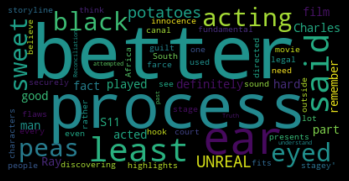

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["br", "href"])
text = " ".join(test_false['text1'].tolist())
wordcloud = WordCloud(stopwords=stopwords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.savefig('wordcloud11.png')
plt.show()

https://github.com/plaban1981/Huggingface_transformers_course/blob/main/FineTuningBERT_Transformers.ipynb

https://colab.research.google.com/drive/18Qqox_QxJkOs80XVYaoLsdum0dX-Ilxb